# **Notebook 2a**: EfficientDet

<span style="font-size: 1.5rem;">By **Michael Farrugia**</span>

## **Environment Setup**

In [69]:
INSTALL_PACKAGES = False

In [70]:
if INSTALL_PACKAGES:
    !pip install -r requirements.txt

In [71]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Dataset Validation**

In [72]:
import json

with open("./dataset/COCO-based_COCO/annotations/train.json", "r") as f:
    train_annotations = json.load(f)

with open("./dataset/COCO-based_COCO/annotations/val.json", "r") as f:
    val_annotations = json.load(f)

with open("./dataset/COCO-based_COCO/annotations/test.json", "r") as f:
    test_annotations = json.load(f)

print(f"Number of images in the train set: {len(train_annotations ['images'])}")
print(f"Number of images in the validation set: {len(val_annotations ['images'])}")
print(f"Number of images in the test set: {len(test_annotations ['images'])}")

Number of images in the train set: 483
Number of images in the validation set: 88
Number of images in the test set: 86


In [73]:
cat_ids = sorted(train_annotations['categories'], key=lambda x: x['id'])
cat_id_to_idx = {cat['id']: idx for idx, cat in enumerate(cat_ids)}


print("Category mapping:")
for cat in cat_ids:
    print(f"  COCO ID {cat['id']} -> Model label {cat_id_to_idx[cat['id']]} ({cat['name']})")

Category mapping:
  COCO ID 1 -> Model label 0 (Blind-Spot Mirror (Convex))
  COCO ID 2 -> Model label 1 (No Entry (One Way))
  COCO ID 3 -> Model label 2 (No Through Road (T-Sign))
  COCO ID 4 -> Model label 3 (Pedestrian Crossing)
  COCO ID 5 -> Model label 4 (Roundabout Ahead)
  COCO ID 6 -> Model label 5 (Stop)


The images used in this notebook are split according to the `.json` files. To use the images in training, the `images` folder must exist - if this folder does not exist, the cell below is used to create the necessary folders according to how the dataset is split, by extracting the original images from each member's folder.

In [74]:
import os
import shutil

if not os.path.exists("./dataset/COCO-based_COCO/images/"):
    os.makedirs("./dataset/COCO-based_COCO/images/")

    for dataset, dataset_type in zip([train_annotations, val_annotations, test_annotations], ["train", "val", "test"]):
        os.makedirs(f"./dataset/COCO-based_COCO/images/{dataset_type}/")
        img_filenames = [img ["file_name"] for img in dataset ["images"]]
        
        for img_filename in img_filenames:
            member_name = img_filename.split("-") [1].split("_") [0]

            img_src_path = f"./{member_name}/images/{img_filename}"
            img_dst_path = f"./dataset/COCO-based_COCO/images/{dataset_type}/{img_filename}"
            
            shutil.copyfile(img_src_path, img_dst_path)

## **Model Setup and Configuration**

In [75]:
from effdet import get_efficientdet_config

config = get_efficientdet_config("efficientdet_d0")
config.num_classes = 6
config.image_size = (512, 512)

In [76]:
from effdet import EfficientDet

effdet_model = EfficientDet(config, pretrained_backbone = True)
effdet_model.to(device)

EfficientDet(
  (backbone): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (co

The `DetBenchTrain` class is used to wrap the EfficientDet model for training. The configuration is modified to suit the dataset used in this assignment.

In [77]:
from effdet import DetBenchTrain

effdet_bench = DetBenchTrain(effdet_model, config)
effdet_bench.to(device)

DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), st

An `AdamW` optimiser is used for training, with a learning rate of `1e-4`.

In [78]:
optimiser = torch.optim.AdamW(effdet_bench.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=3)

Next, the `torch` dataset and dataloader are created for training and validation. This also includes defining a `train_transform` and `test_transform` function to preprocess the images and annotations for EfficientDet.

In [79]:
import albumentations as A

def train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p = 0.5),
        A.ShiftScaleRotate(shift_limit = 0.0625, scale_limit = 0.1, rotate_limit = 15, p = 0.5),
        A.RandomBrightnessContrast(p = 0.5),
        A.ColorJitter(p = 0.5),
        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        A.pytorch.ToTensorV2()
    ], bbox_params = A.BboxParams(format = "coco", label_fields = ["labels"], min_area = 0, min_visibility = 0))

def test_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        A.pytorch.ToTensorV2()
    ], bbox_params = A.BboxParams(format = "coco", label_fields = ["labels"], min_area = 0, min_visibility = 0))

In [80]:
import cv2

class EfficientDetDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, img_dir, cat_id_to_idx, transform = None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.cat_id_to_idx = cat_id_to_idx
        self.transform = transform

        self.img_id_to_annotations = {}
        for annotation in self.annotations ["annotations"]:
            img_id = annotation ["image_id"]
            if img_id not in self.img_id_to_annotations:
                self.img_id_to_annotations [img_id] = []
            self.img_id_to_annotations [img_id].append(annotation)

        self.imgs = {img ["id"]: img for img in self.annotations ["images"]}
        self.img_ids = list(self.imgs.keys())

    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, index):
        img_id = self.img_ids [index]
        img_info = self.imgs [img_id]
        img_path = os.path.join(self.img_dir, img_info ["file_name"])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Original size is kept for reference, but the model will use the resized 512x512
        orig_h, orig_w = image.shape[:2]

        annotations = self.img_id_to_annotations.get(img_id, [])
        
        # Albumentations 'coco' format expects [x_min, y_min, width, height]
        bboxes = [annotation ["bbox"] for annotation in annotations]
        labels = [self.cat_id_to_idx[annotation ["category_id"]] for annotation in annotations]

        if self.transform:
            # IMPORTANT: Passing bboxes and labels into the transform ensures 
            # they are scaled from the original size to 512x512 automatically.
            transformed = self.transform(image=image, bboxes=bboxes, labels=labels)
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["labels"]

        # Convert the scaled COCO format to XYXY for the EfficientDet model
        if len(bboxes) > 0:
            bboxes_xyxy = []
            for bbox in bboxes:
                x, y, w, h = bbox
                # Clipping to ensure coordinates stay within the 512x512 boundary
                bboxes_xyxy.append([
                    max(0, x), 
                    max(0, y), 
                    min(512, x + w), 
                    min(512, y + h)
                ])
            
            bboxes = torch.tensor(bboxes_xyxy, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            bboxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        # target['img_size'] and target['img_scale'] are used by effdet to 
        # map predictions back to the original image resolution during evaluation.
        target = {
            "boxes": bboxes,
            "labels": labels,
            "img_size": torch.tensor([512, 512], dtype=torch.float32),
            "img_scale": torch.tensor([1.0], dtype=torch.float32)
        }

        return image, target

In [81]:
train_dataset = EfficientDetDataset(
    annotations = train_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/train/",
    cat_id_to_idx = cat_id_to_idx,
    transform = train_transform()
)

val_dataset = EfficientDetDataset(
    annotations = val_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/val/",
    cat_id_to_idx = cat_id_to_idx,
    transform = test_transform()
)

c:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


A collate function is also defined to handle batches with varying numbers of annotations.

In [82]:
def efficientdet_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)

    max_objs = max(target ["boxes"].shape [0] for target in targets)

    padded_boxes = []
    padded_labels = []
    img_sizes = []
    img_scales = []

    for target in targets:
        boxes = target ["boxes"]
        labels = target ["labels"]

        num_objs = boxes.shape [0]

        padded_box = torch.zeros((max_objs, 4), dtype = torch.float32)
        padded_label = torch.full((max_objs,), -1, dtype = torch.int64)

        if num_objs > 0:
            padded_box [:num_objs, :] = boxes
            padded_label [:num_objs] = labels

        padded_boxes.append(padded_box)
        padded_labels.append(padded_label)
        img_sizes.append(target["img_size"])
        img_scales.append(target["img_scale"])

    padded_boxes = torch.stack(padded_boxes)
    padded_labels = torch.stack(padded_labels)
    img_sizes = torch.stack(img_sizes)
    img_scales = torch.stack(img_scales)

    return images, {
        "bbox": padded_boxes, 
        "cls": padded_labels,
        "img_size": img_sizes,
        "img_scale": img_scales
    }

In [83]:
train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

In [84]:
val_dataset_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

Finally, the `tensorboard` writer is initialised to log training and validation metrics during the training process.

In [85]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("work_dirs/efficientdet_sign_type")

The cell below checks whether the dataset loaders are working correctly, by visualising some images and their corresponding bounding boxes and labels.

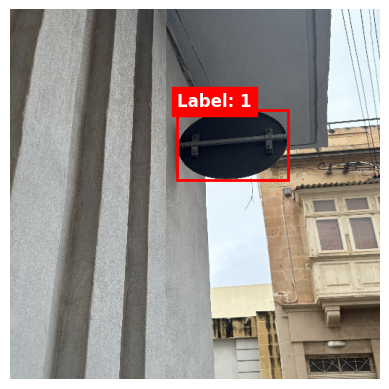

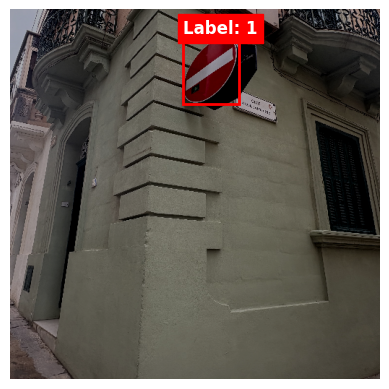

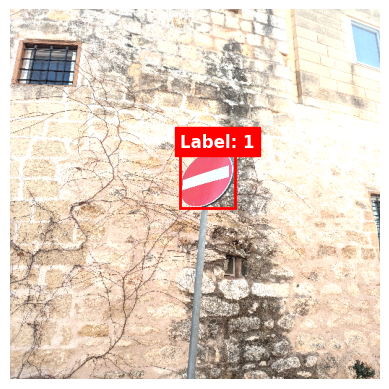

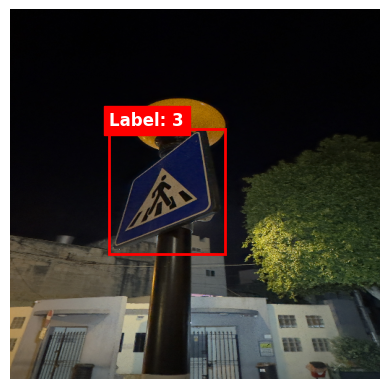

In [86]:
import matplotlib.pyplot as plt

# get first train batch for visualisation
train_images, train_targets = next(iter(train_dataset_loader))

for train_image, train_bbox, train_label in zip(train_images, train_targets ["bbox"], train_targets ["cls"]):
    img = train_image.permute(1, 2, 0)
    
    # multiply by mean and std to denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])

    plt.imshow(img)
    ax = plt.gca()

    for bbox, label in zip(train_bbox, train_label):
        if label.item() < 0:
            continue

        x_min, y_min, x_max, y_max = bbox.tolist()
        width = x_max - x_min
        height = y_max - y_min

        rect = plt.Rectangle((x_min, y_min), width, height, fill = False, color = "red", linewidth = 2)
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"Label: {label.item()}", color = "white", fontsize = 12, weight = "bold", backgroundcolor = "red")

    plt.axis("off")
    plt.show()

## **Model Training**

In [ ]:
NUM_EPOCHS = 15

In [ ]:
import time

training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    effdet_bench.train()
    epoch_loss = 0
    epoch_class_loss = 0
    epoch_box_loss = 0

    for batch_idx, (images, targets) in enumerate(train_dataset_loader):
        images = images.to(device)
        targets = {k: v.to(device) for k, v in targets.items()}

        optimiser.zero_grad()

        loss_dict = effdet_bench(images, targets)
        loss = loss_dict ["loss"]
        class_loss = loss_dict ["class_loss"]
        box_loss = loss_dict ["box_loss"]
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
        epoch_class_loss += class_loss.item()
        epoch_box_loss += box_loss.item()

        global_step = epoch * len(train_dataset_loader) + batch_idx
        writer.add_scalar("Loss/batch", loss.item(), global_step)

    avg_loss = epoch_loss / len(train_dataset_loader)
    avg_class_loss = epoch_class_loss / len(train_dataset_loader)
    avg_box_loss = epoch_box_loss / len(train_dataset_loader)

    writer.add_scalar("Loss/train_epoch", avg_loss, epoch)
    writer.add_scalar("Loss/train_class_loss", avg_class_loss, epoch)
    writer.add_scalar("Loss/train_box_loss", avg_box_loss, epoch)
    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_class_loss = 0
        val_epoch_box_loss = 0

        for batch_idx, (images, targets) in enumerate(val_dataset_loader):
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}

            loss_dict = effdet_bench(images, targets)
            loss = loss_dict ["loss"]
            class_loss = loss_dict ["class_loss"]
            box_loss = loss_dict ["box_loss"]

            val_epoch_loss += loss.item()
            val_epoch_class_loss += class_loss.item()
            val_epoch_box_loss += box_loss.item()

    avg_val_loss = val_epoch_loss / len(val_dataset_loader)
    avg_val_class_loss = val_epoch_class_loss / len(val_dataset_loader)
    avg_val_box_loss = val_epoch_box_loss / len(val_dataset_loader)
    
    writer.add_scalar("Loss/val_epoch", avg_val_loss, epoch)
    writer.add_scalar("Loss/val_class_loss", avg_val_class_loss, epoch)
    writer.add_scalar("Loss/val_box_loss", avg_val_box_loss, epoch)
    
    epoch_duration = time.time() - epoch_start_time
    writer.add_scalar("Time/epoch_duration", epoch_duration, epoch)

    print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Class: {avg_class_loss:.4f}, Val Class: {avg_val_class_loss:.4f}, Train Box: {avg_box_loss:.4f}, Val Box: {avg_val_box_loss:.4f}, Time: {epoch_duration:.2f}s")

total_training_time = time.time() - training_start_time
writer.add_scalar("Time/total_training_time", total_training_time, 0)
print(f"\nTotal training time: {total_training_time:.2f}s ({total_training_time / 60:.2f} minutes)")

writer.close()

### Model Saving

In [ ]:
os.makedirs("./work_dirs/efficientdet_sign_type", exist_ok = True)

torch.save({
    "epoch": 10,
    "model_state_dict": effdet_model.state_dict(),
    "optimizer_state_dict": optimiser.state_dict(),
    "config": config,
}, "./work_dirs/efficientdet_sign_type/efficientdet_signd0_sign_type_final.pth")

print("Model saved to ./work_dirs/efficientdet_sign_type/efficientdet_signd0_sign_type_final.pth")

## **Model Evaluation**

The model is then evaluated on the test set, calculating metrics like Mean Average Precision (mAP), Average Precision 50 (AP50), and Average Precision 75 (AP75) to assess its performance.

In [ ]:
test_dataset = EfficientDetDataset(
    annotations = test_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/test/",
    cat_id_to_idx = cat_id_to_idx,
    transform = test_transform()
)

test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

In [ ]:
from effdet import DetBenchPredict

effdet_predict = DetBenchPredict(effdet_model)
effdet_predict.cpu()
effdet_predict.eval()

In [ ]:
from tqdm import tqdm

preds = []
targets = []

with torch.no_grad():
    for images, batch_targets in tqdm(test_dataset_loader):
        images = images.cpu()

        outputs = effdet_predict(images)

        for i in range(images.shape [0]):
            output = outputs [i]
            target_boxes = batch_targets ["bbox"] [i]
            target_labels = batch_targets ["cls"] [i]

            mask = output [:, 4] > 0.05
            valid_output = output [mask]

            pred_boxes = valid_output[:, [1, 0, 3, 2]].cpu()
            pred_scores = valid_output [:, 4].cpu()
            pred_labels = valid_output [:, 5].cpu().int()

            preds.append({
                "boxes": pred_boxes,
                "scores": pred_scores,
                "labels": pred_labels
            })

            valid_gt_mask = target_labels >= 0
            gt_boxes = target_boxes [valid_gt_mask].cpu()
            gt_labels = target_labels [valid_gt_mask].cpu().int()

            targets.append({
                "boxes": gt_boxes,
                "labels": gt_labels
            })

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

map_metric = MeanAveragePrecision(class_metrics = True)
map_metric.update(preds, targets)
results = map_metric.compute()

In [ ]:
for key, value in results.items():
    print(f"{key}: {value}")